# 糖尿病数据探索和分类

Pima Indians Diabetes Data Set是一个皮马印第安人糖尿病数据集，根据现有的医疗信息预测5年内皮马印第安人糖尿病发作的概率。     
数据集来源：https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes 。 
   

数据集共9个字段：
0列为怀孕次数；
1列为口服葡萄糖耐量试验中2小时后的血浆葡萄糖浓度；
2列为舒张压（单位:mm Hg）；
3列为三头肌皮褶厚度（单位：mm）；
4列为餐后血清胰岛素（单位:mm）；
5列为体重指数（体重（公斤）/ 身高（米）^2）；
6列为糖尿病家系作用；
7列为年龄；
8列为分类变量（0或1，出现糖尿病为1，否则为0）。
 
 

# 1. 读取数据，数据处理

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D 

%matplotlib inline

In [2]:
data = pd.read_csv("diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## 填补缺失值

In [6]:
#  统计输入特征中数值为0的数量 

input_data = data.drop('Outcome',axis=1)
count = (input_data==0).sum().sort_values(ascending=False)               
rate = count/len(input_data)
miss_data = pd.concat([count,rate],axis=1,keys=['count','rate'])           # 生成缺失总数与比例的列表
print('输入特征中数值为0的数量和比例：\n',miss_data)

输入特征中数值为0的数量和比例：
                           count      rate
Insulin                     374  0.486979
SkinThickness               227  0.295573
Pregnancies                 111  0.144531
BloodPressure                35  0.045573
BMI                          11  0.014323
Glucose                       5  0.006510
Age                           0  0.000000
DiabetesPedigreeFunction      0  0.000000


从结果看到有很多特征的值为0，但对于某些特征，0值没有意义，表示该值无效或为缺失值。下面这些特征如果是0就没有意义：   
1、血浆葡萄糖浓度    
2、舒张压   
3、肱三头肌皮褶厚度   
4、餐后血清胰岛素   
5、体重指数    
因此对于这些特征用中位数替代0值。

In [7]:
# 对输入特征中的0值用中位数填补 
    
miss_col = miss_data[miss_data['rate'] > 0].index              # 有0值的输入特征变量名称
for c in miss_col:
    cMedian = data.loc[data[c]!=0][c].median()                  # 中位数
    data[c] = data[c].apply(lambda x:cMedian if x==0 else x)  # 如果是0，填补成中位数

data_null = (data[miss_col]==0).sum().sort_values(ascending=False)   # 检查输入特征中是否还有0值
print('缺失值:\n',data_null)

缺失值:
 Glucose          0
BMI              0
BloodPressure    0
Pregnancies      0
SkinThickness    0
Insulin          0
dtype: int64


# 2.  数据探索，特征之间的相关性

Text(0,0.5,'Number of occurences')

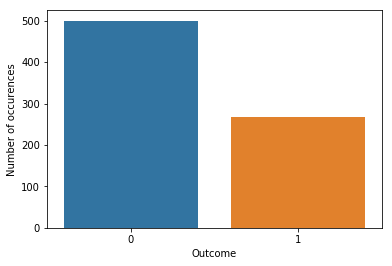

In [8]:
# 查看两类样本分布是否均衡

sns.countplot(data.Outcome)
plt.xlabel('Outcome')
plt.ylabel('Number of occurences')

# 由下图看到，类别标签为0（也就是没有糖尿病）的比类别标签为1的数多近1倍。样本不是很均衡。

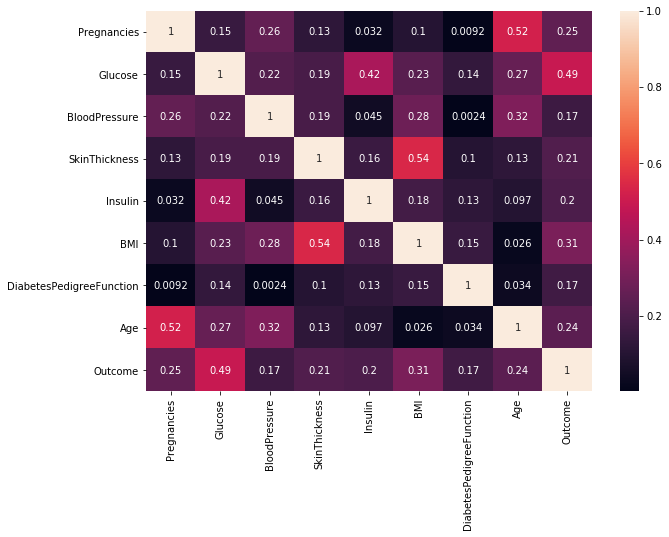

In [9]:
# 查看数据两两之间的相关性

data_corr = data.corr().abs()
plt.subplots(figsize=(10, 7))
sns.heatmap(data_corr,annot=True)

In [11]:
# 查看高相关系数的特征

cols=data.columns
threshold = 0.3   # 由上图看到，相关系数大多都不高，因此这里阈值用0.3
corr_list = []
size = data_corr.shape[0]

for i in range(0, size):  
    for j in range(i+1,size):  
        if (data_corr.iloc[i,j] >= threshold and data_corr.iloc[i,j] < 1) or (data_corr.iloc[i,j] < 0 and data_corr.iloc[i,j] <= -threshold):
            corr_list.append([data_corr.iloc[i,j],i,j]) 
             
sorted_corr = sorted(corr_list,key=lambda x: -abs(x[0]))

for v,i,j in sorted_corr:
    print ("%s and %s = %.2f" % (cols[i],cols[j],v))

SkinThickness and BMI = 0.54
Pregnancies and Age = 0.52
Glucose and Outcome = 0.49
Glucose and Insulin = 0.42
BloodPressure and Age = 0.32
BMI and Outcome = 0.31


1） 很多输入特征之间没有高相关性，相关系数 >0.5的特征是‘Pregnancies’和‘Age’，'SkinThickness' 和 'BMI'。   
2） 在所有的输入特征中，‘Glucose’和类别特征('Outcome')有最高的相关系数，为0.49。

In [12]:
# 把样本分开，分为输入特征，和输出类别特征。

X_train=data.drop("Outcome",axis=1)
y_train=data['Outcome'] 

Text(0.5,0,'label')

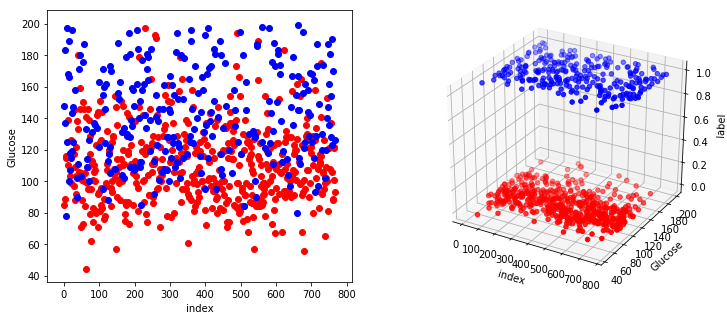

In [13]:
# 作图看一下样本的特性
# 根据上面相关系数分析，查看与类别特征'Outcome'有最高的相关系数(0.49)的输入特征'Glucose'的数据分布情况

# 对输入特征按标签类别分类
x1=[];x2=[]    #  存储输入特征
d1=[];d2=[]    #  存储输入特征的索引号
z1=[];z2=[]    #  存储类别标签

q=data.columns  # 输入特征名称
X_train=np.array(X_train)

for i in range(len(y_train)):
    if y_train[i]==0:
        x1.append(X_train[i,:])
        d1.append([i])
        z1.append([0])
    else:
        x2.append(X_train[i,:])
        d2.append([i])
        z2.append([1])
x1=np.array(x1)
x2=np.array(x2)


# 查看'Glucose’(q[1])的数据分布情况
# 画x-y平面图，两个类别标签的数据点重合在一起，无法分辨
fig=plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(d1,x1[:,1],c='red')
plt.scatter(d2,x2[:,1],c='blue')
plt.xlabel('index')
plt.ylabel(q[1])

# 画x-y-z 3维图，把两个类别标签的数据点分开，易于分辨
ax=plt.subplot(122,projection='3d')
ax.scatter(d1,x1[:,1],z1,c='red')
ax.scatter(d2,x2[:,1],z2,c='blue')
ax.set_xlabel('index')
ax.set_ylabel(q[1])
ax.set_zlabel('label')


Text(0.5,0,'label')

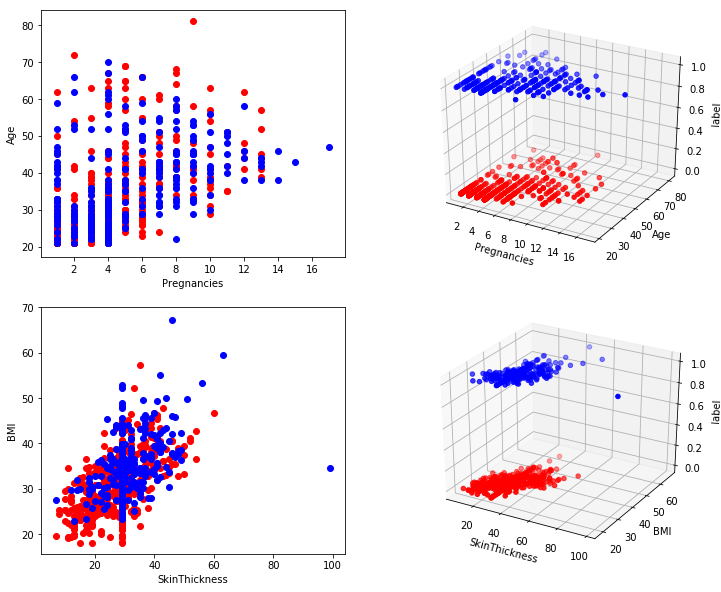

In [14]:
# 查看相关系数 >0.5的两个特征‘Pregnancies’和‘Age’，'SkinThickness' 和 'BMI'的数据分布情况
# q[0] = 'Pregnancies’; q[7]='Age'
# q[3] = 'SkinThickness’; q[5]='BMI'

# 画x-y平面图，两个类别标签的数据点重合在一起，无法分辨
fig=plt.figure(figsize=(12,10))
plt.subplot(221)
plt.scatter(x1[:,0],x1[:,7],c='red')
plt.scatter(x2[:,0],x2[:,7],c='blue')
plt.xlabel(q[0])
plt.ylabel(q[7])

plt.subplot(223)
plt.scatter(x1[:,3],x1[:,5],c='red')
plt.scatter(x2[:,3],x2[:,5],c='blue')
plt.xlabel(q[3])
plt.ylabel(q[5])

# 画x-y-z 3维图，把两个类别标签的数据点分开，易于分辨
ax=plt.subplot(222,projection='3d')
ax.scatter(x1[:,0],x1[:,7],z1,c='red')
ax.scatter(x2[:,0],x2[:,7],z2,c='blue')
ax.set_xlabel(q[0])
ax.set_ylabel(q[7])
ax.set_zlabel('label')

ax=plt.subplot(224,projection='3d')
ax.scatter(x1[:,3],x1[:,5],z1,c='red')
ax.scatter(x2[:,3],x2[:,5],z2,c='blue')
ax.set_xlabel(q[3])
ax.set_ylabel(q[5])
ax.set_zlabel('label')

由上面数据分布特性图可以看到：   
1）在二维平面中是无法把两个类别特征对应的数据分开的。    
2）只能在三维或更高维数的立体图中把数据分开，对数据归类。   
3）下面的Logistic Regression和SVM回归的目的就是要找到一个超平面或曲面划分数据，对输入特征正确归类。

# 3. SVM回归  
用以下三种SVM回归方法训练模型：   
1) default SVC；     
2) 线性SVM；   
3) RBF核SVM。    
优化正则系数C，核函数宽度gamma，以达到提高正确率的目的。

## 数据预处理

In [15]:
from sklearn.preprocessing import StandardScaler 
ss_X = StandardScaler() 
X_train = ss_X.fit_transform(X_train)

训练数据和测试数据分割(随机选择20%的数据作为测试集)

In [32]:
from sklearn.model_selection import train_test_split

X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, train_size = 0.8,random_state = 0)

## 1) default SVC

In [33]:
from sklearn.svm import LinearSVC
from sklearn import metrics

SVC1 = LinearSVC().fit(X_train_part, y_train_part)
y_predict = SVC1.predict(X_val)     # 在校验集上测试，估计模型性能
accuracy = SVC1.score(X_val,y_val)

print("正确率： accuracy =",accuracy)
print("\n分类报告:\n%s:\n%s\n" % (SVC1, metrics.classification_report(y_val, y_predict)))
print("混淆矩阵:\n%s" % metrics.confusion_matrix(y_val, y_predict))

正确率： accuracy = 0.8181818181818182

分类报告:
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0):
             precision    recall  f1-score   support

          0       0.84      0.92      0.88       107
          1       0.76      0.60      0.67        47

avg / total       0.81      0.82      0.81       154


混淆矩阵:
[[98  9]
 [19 28]]


说明:  

1. 分类报告(classificatino report)：     
1) 索引0和1表示类别特征(没有糖尿病和有糖尿病)；  
2) 精度(precision) = 正确预测的个数(TP)/被预测正确的个数(TP+FP)；  
3) 召回率(recall) = 正确预测的个数(TP)/预测个数(TP+FN)；  
4) 调和平均(f1-score) = 2×精度×召回率/(精度+召回率)；  
5) support: 样本数。类别特征为0的样本有107个，类别特征为1的样本有47个；  
6) 最后一行表示正确率：等于各指标的加权平均值，如 0.81 = （107×0.88 +47×0.67）/ (107+47)。   
  
2. 混淆矩阵（confusion matrix）： 
1) 用矩阵来呈现模型预测性能的可视化效果；
2) 矩阵的纵向表示实际的类别特征，横向表示预测的类别特征。

预测结果：    
1) 对于类别特征0：总共有107个样本，98个预测准确，被预测成0；9个预测错误，被预测成1。      
    P0 = 98/(98+19)=0.84，R0 = 98/(98+9)=0.92  
2) 对于类别特征1：总共有47个样本， 28个预测准确，被预测成1；19个预测错误，被预测成0。         
    P1 = 28/(28+9)=0.76， R1 = 28/(28+19)=0.60  

结论：   
1) 对于有糖尿病的病人，有40%的人会被预测成没有糖尿病 （(1-0.60) × 100% = 40% ）。     
2) 被预测成糖尿病的人里面，有24%的人实际上没有糖尿病 （(1-0.76) × 100% = 24% ）。    
3) 对于没有糖尿病的人，有8%的人会被预测成有糖尿病 （(1-0.92) × 100% = 8% ）。    
4) 被预测成没有糖尿病的人里面，有16%的人实际上是有糖尿病的（(1-0.84) × 100% = 16% ）。   

default SVC 模型的正确率是0.82。 


## 2) 线性SVM
优化正则系数

accuracy:   0.7987012987012987
accuracy:   0.8246753246753247
accuracy:   0.8246753246753247
accuracy:   0.8246753246753247
accuracy:   0.8181818181818182
accuracy:   0.7857142857142857


No handles with labels found to put in legend.


accuracy:   0.7727272727272727

最大正确率：  0.8246753246753247
最佳参数:     C = 0.01


Text(0,0.5,'accuracy')

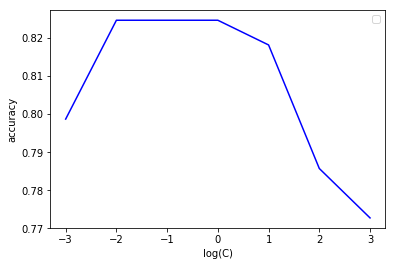

In [34]:
# 定义一个模型训练函数，采用交叉验证，用校验集（X_val、y_val）来估计模型性能
def fit_grid_point_Linear(C, X_train, y_train, X_val, y_val):
    SVC2 =  LinearSVC( C = C)
    SVC2 = SVC2.fit(X_train, y_train) 
    accuracy = SVC2.score(X_val, y_val)
    print("accuracy:  ",accuracy)
    return accuracy

# 正则系数C范围
C_s = np.logspace(-3, 3, 7)  

# 不同正则系数C时，得到的模型的正确率 
accuracy_s = []
for i, oneC in enumerate(C_s):
    tmp = fit_grid_point_Linear(oneC, X_train, y_train, X_val, y_val)
    accuracy_s.append(tmp)
accuracy_s=np.array(accuracy_s)

# 找出最大正确率和最佳正则参数
max_accuracy=np.max(accuracy_s)
best_C=C_s[accuracy_s.tolist().index(max_accuracy)]
print('\n最大正确率： ',max_accuracy)
print('最佳参数:     C =',best_C)


# 画正则系数与正确率的关系图
x_axis = np.log10(C_s)
plt.plot(x_axis, accuracy_s, 'b-')
plt.legend()
plt.xlabel( 'log(C)' )                                                                                                      
plt.ylabel( 'accuracy' )


In [35]:
# 最佳参数C=0.01时，得到的分类报告和混肴矩阵

SVC2 =  LinearSVC( C = 0.01)
SVC2 = SVC2.fit(X_train, y_train) 
 
y_predict = SVC2.predict(X_val)

print("分类报告:\n%s:\n%s\n" % (SVC2, metrics.classification_report(y_val, y_predict)))
print("混淆矩阵:\n%s" % metrics.confusion_matrix(y_val, y_predict))

分类报告:
LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0):
             precision    recall  f1-score   support

          0       0.84      0.92      0.88       107
          1       0.76      0.62      0.68        47

avg / total       0.82      0.82      0.82       154


混淆矩阵:
[[98  9]
 [18 29]]


线性SVM模型训练结论：     
1. 线性SVM模型的正确率是0.82，与 default SVC 模型的正确率0.82相同。   
2. 由分类报告和混肴矩阵得到：   
1) 对于有糖尿病的病人，有38%的人会被预测成没有糖尿病。     
2) 被预测成糖尿病的人里面，有26%的人实际上没有糖尿病。    
3) 对于没有糖尿病的人，有8%的人会被预测成有糖尿病。    
4) 被预测成没有糖尿病的人里面，有16%的人实际上是有糖尿病的。   

## 3) RBF核SVM 
优化正则系数C，以及核函数宽度gamma

accuracy=
 [[0.69480519 0.69480519 0.69480519 0.69480519 0.69480519]
 [0.74675325 0.81168831 0.69480519 0.69480519 0.69480519]
 [0.80519481 0.85064935 0.97402597 1.         1.        ]
 [0.80519481 0.88961039 1.         1.         1.        ]
 [0.81168831 0.94155844 1.         1.         1.        ]]

最大正确率：  1.0
最佳参数:     C = 1.0   gamma = 10.0


Text(0,0.5,'accuracy')

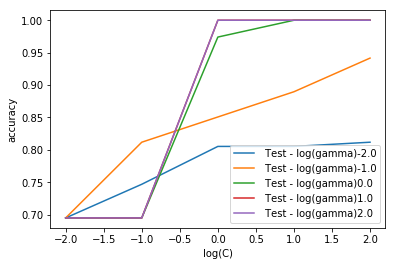

In [36]:
from sklearn.svm import SVC

# 定义一个模型训练函数，采用交叉验证，用校验集（X_val、y_val）来估计模型性能
def fit_grid_point_RBF(C, gamma, X_train, y_train, X_val, y_val):
    SVC3 =  SVC( C = C,kernel='rbf',gamma = gamma)
    SVC3 = SVC3.fit(X_train, y_train)
    accuracy = SVC3.score(X_val, y_val)   
    return accuracy

# 正则参数范围
C_s = np.logspace(-2, 2, 5)
gamma_s = np.logspace(-2, 2, 5)  

# 求不同参数下的正确率
accuracy_s = []
for c in C_s:
    a=[]
    for g in gamma_s:
        a.append(fit_grid_point_RBF(c,g, X_train, y_train, X_val, y_val))
    accuracy_s.append(a)      
accuracy_s = np.array(accuracy_s) 
print('accuracy=\n',accuracy_s)

# 找出最大正确率和最佳正则参数
max_accuracy=0
x=0; y=0
for i in range(len(C_s)):
    for j in range(len(gamma_s)):
        if accuracy_s[i,j] > max_accuracy:
            max_accuracy = accuracy_s[i,j]
            x = i;y = j  
best_C = C_s[x]
best_gamma = gamma_s[y]
print('\n最大正确率： ',max_accuracy)
print('最佳参数:     C =',best_C,'  gamma =',best_gamma)
        
# 画不同核函数宽度下，正则系数与正确率的关系图
x_axis = np.log10(C_s)
for j, gamma in enumerate(gamma_s):
    plt.plot(x_axis, np.array(accuracy_s[:,j]), label = ' Test - log(gamma)' + str(np.log10(gamma)))
plt.legend()
plt.xlabel( 'log(C)' )                                                                                                      
plt.ylabel( 'accuracy' )


In [37]:
# 最佳参数C=1，gamma=10时，得到的分类报告和混肴矩阵

SVC3 =  SVC( C = 1, kernel='rbf', gamma = 10)
SVC3 = SVC3.fit(X_train, y_train)    

y_predict = SVC3.predict(X_val)

print("分类报告:\n%s:\n%s\n" % (SVC3, metrics.classification_report(y_val, y_predict)))
print("混淆矩阵:\n%s" % metrics.confusion_matrix(y_val, y_predict))

分类报告:
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       107
          1       1.00      1.00      1.00        47

avg / total       1.00      1.00      1.00       154


混淆矩阵:
[[107   0]
 [  0  47]]


RBF核SVM模型训练结论：     
1. RBF核SVM 模型的正确率是1，比default SVC、线性SVM模型的正确率高。   
2. 由分类报告和混肴矩阵得到：   
1) 对于有糖尿病的病人(类别特征1)，能够全部被预测成有糖尿病。        
2) 对于没有糖尿病的人(类别特征0)，能够全部被预测成没有糖尿病。    


# 总结：

1 数据探索表明，很多输入特征之间没有高相关性，相关系数 >0.5的特征是‘Pregnancies’和‘Age’，'SkinThickness' 和 'BMI'。在所有的输入特征中，‘Glucose’和类别特征('Outcome')有最高的相关系数，为0.49。


2 数据分布特性图表明，在二维平面中无法把两个类别特征对应的数据分开，只能在多维空间中用超平面划分数据，对输入特征正确归类。


3 用三种SVM回归方法：default SVC、线性SVM、 RBF核SVM训练模型，得到：           
3.1 default SVC 和线性SVM模型得到的正确率都是0.82，最佳正则参数是C =0.1。    
具体的预测结果：对于有糖尿病的病人，有40%的人会被预测成没有糖尿病；对于没有糖尿病的人，有8%的人会被预测成有糖尿病。       
3.2 RBF核SVM得到的最大正确率是1，最佳正则参数是C =1，核函数宽度gamma=10。    
具体的预测结果：对于有糖尿病的病人(类别特征1)，能够全部被预测成有糖尿病；对于没有糖尿病的人(类别特征0)，能够全部被预测成没有糖尿病。